In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), VGG network will be used in this project. Specifically, VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [4]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

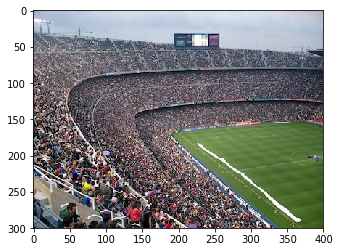

In [6]:
content_image = scipy.misc.imread("images/camp-nou.jpg")
imshow(content_image);

In [7]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled))/(4*n_H*n_W*n_C)
    return J_content

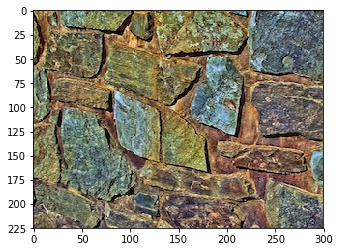

In [8]:
style_image = scipy.misc.imread("images/stone_style.jpg")
imshow(style_image);

In [9]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """

    GA = tf.matmul(A, A, transpose_a=False, transpose_b=True)
    return GA

In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.reshape(tf.transpose(a_S), shape=[n_C, -1])
    a_G = tf.reshape(tf.transpose(a_G), shape=[n_C, -1])

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4*((n_H*n_W)**2)*(n_C**2))
    return J_style_layer

In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]
        a_S = sess.run(out)
        
        #Later will be evaluated, when style image is input for model
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    J = alpha*J_content + beta*J_style
    return J

In [14]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [15]:
content_image = scipy.misc.imread("images/camp-nou.jpg")
content_image = reshape_and_normalize_image(content_image)

In [16]:
style_image = scipy.misc.imread("images/stone_style.jpg")
style_image = reshape_and_normalize_image(style_image)

#### Generated image correlated with content image
initialize the "generated" image as a noisy image created from the content_image.

* The generated image is slightly correlated with the content image.
* By initializing the pixels of the generated image to be mostly noise but slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


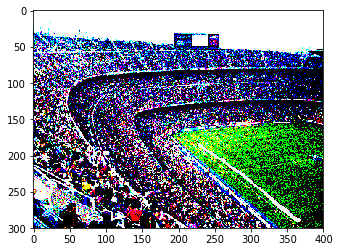

In [17]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [18]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [23]:
J_style = compute_style_cost(model, STYLE_LAYERS)
J = total_cost(J_content, J_style,10,40)
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [28]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model.
    sess.run(model["input"].assign(input_image))
    
    for i in range(num_iterations):
    
        #minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model["input"])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [29]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 2457853700.0
content cost = 5858.9844
style cost = 61444880.0
Iteration 20 :
total cost = 281844100.0
content cost = 6113.9434
style cost = 7044573.5
Iteration 40 :
total cost = 98461150.0
content cost = 5912.246
style cost = 2460050.8
Iteration 60 :
total cost = 51517456.0
content cost = 5603.2173
style cost = 1286535.6
Iteration 80 :
total cost = 34315092.0
content cost = 5352.4893
style cost = 856539.25
Iteration 100 :
total cost = 26208902.0
content cost = 5172.1323
style cost = 653929.5
Iteration 120 :
total cost = 21601512.0
content cost = 5028.9556
style cost = 538780.56
Iteration 140 :
total cost = 18494570.0
content cost = 4897.6753
style cost = 461139.84
Iteration 160 :
total cost = 16193259.0
content cost = 4776.783
style cost = 403637.28
Iteration 180 :
total cost = 14392185.0
content cost = 4664.397
style cost = 358638.53


array([[[[ -91.86109  ,  -65.45453  ,   79.60806  ],
         [ -55.7705   ,  -43.21433  ,   73.43153  ],
         [ -41.395718 ,  -22.689323 ,   57.641754 ],
         ...,
         [  -9.662691 ,  -13.263503 ,   66.888145 ],
         [ -15.421179 ,   22.908123 ,   63.514736 ],
         [ -24.50884  ,   31.990324 ,   42.866478 ]],

        [[ -32.642883 ,   42.395176 ,  113.12711  ],
         [ -45.33316  ,    4.1780195,   80.2834   ],
         [ -34.466087 ,  -17.218935 ,  131.86446  ],
         ...,
         [  -4.8858304,   18.926039 ,   90.39051  ],
         [  -9.312228 ,   19.776318 ,   78.391594 ],
         [   5.1154323,   32.864887 ,   59.511448 ]],

        [[  73.06764  ,   63.31101  ,   87.880585 ],
         [  62.453403 ,   62.580704 ,   86.53887  ],
         [  11.043774 ,   62.859024 ,   98.25288  ],
         ...,
         [  14.212043 ,   27.82159  ,   85.93745  ],
         [  -5.839913 ,    9.518917 ,   68.978615 ],
         [  -8.528561 ,   10.69209  ,   71.83434  ]],

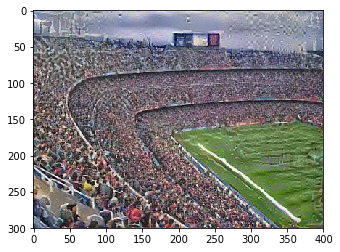

In [30]:
style_image = scipy.misc.imread('output/generated_image.jpg')
imshow(style_image);